In [2]:
from transformers import AutoTokenizer, AutoModel
import torch

In [3]:
model = AutoModel.from_pretrained('bert-base-uncased')

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
text = ['glycine cleavage system protein H',
 'interacts_with',
 'Calcium ion',
 'interacts_with',
 'HtrA serine peptidase 2',
 'interacts_with',
 'Hematologic Diseases']

text = tokenizer.sep_token.join(text)

all_ents = ''.join(text.split(tokenizer.sep_token)).split('interacts_with')

In [27]:

offsets = {ent: (text.find(ent), text.find(ent)+len(ent)) for ent in all_ents}

tokenized_data =  tokenizer(text, return_offsets_mapping=True, return_tensors = 'pt')

In [28]:
inputs = {k:v for k, v in tokenized_data.items() if k!='offset_mapping'}

with torch.no_grad():
    model_out = model(**inputs)

In [29]:
lhs = model_out[0]
lhs = lhs.reshape(-1,768)

In [30]:
offsets

{'glycine cleavage system protein H': (0, 33),
 'Calcium ion': (57, 68),
 'HtrA serine peptidase 2': (92, 115),
 'Hematologic Diseases': (139, 159)}

In [73]:
def get_embeds(token_offsets, offsets_mapping, last_hidden_state):
    offsets_mapping = offsets_mapping.squeeze(0)[1:-1]
    embeds = {}
    for word, token_offset in token_offsets.items():
        start, end = token_offset
        new_start = (offsets_mapping[:, 0]==start).nonzero(as_tuple=True)
        new_end = (offsets_mapping[:, 1]==end).nonzero(as_tuple=True)
        embs = last_hidden_state[new_start[0]+1: new_end[0]+1]
        embeds[word] = embs.mean(dim=0)
        
    return embeds   
        

In [91]:
embeds = get_embeds(offsets, tokenized_data['offset_mapping'], lhs)

In [92]:
for k, v in embeds.items():
    print(k, v.shape)

glycine cleavage system protein H torch.Size([768])
Calcium ion torch.Size([768])
HtrA serine peptidase 2 torch.Size([768])
Hematologic Diseases torch.Size([768])


In [88]:
from sklearn.manifold import TSNE
import numpy as np

In [95]:
tsne = TSNE(n_components=2)
# embeds = np.array(list(embeds.values()))

embeds = [embeds[k].numpy() for k in sorted(embeds.keys())]
tsne_embeds = tsne.fit_transform(embeds)

C:\Users\mihir\PycharmProjects\assignment-2-env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\mihir\PycharmProjects\assignment-2-env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [96]:
import matplotlib.pyplot as plt

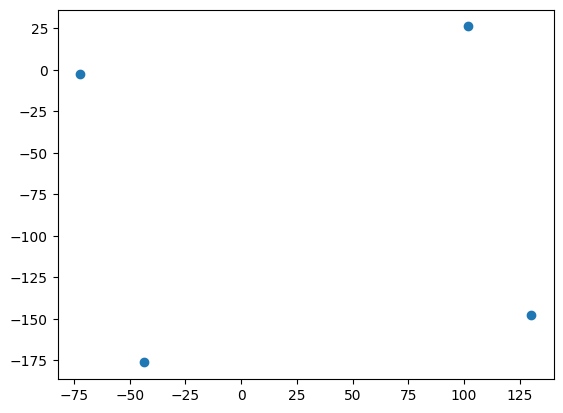

In [97]:
plt.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\mihir\PycharmProjects\assignment-2-env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
 

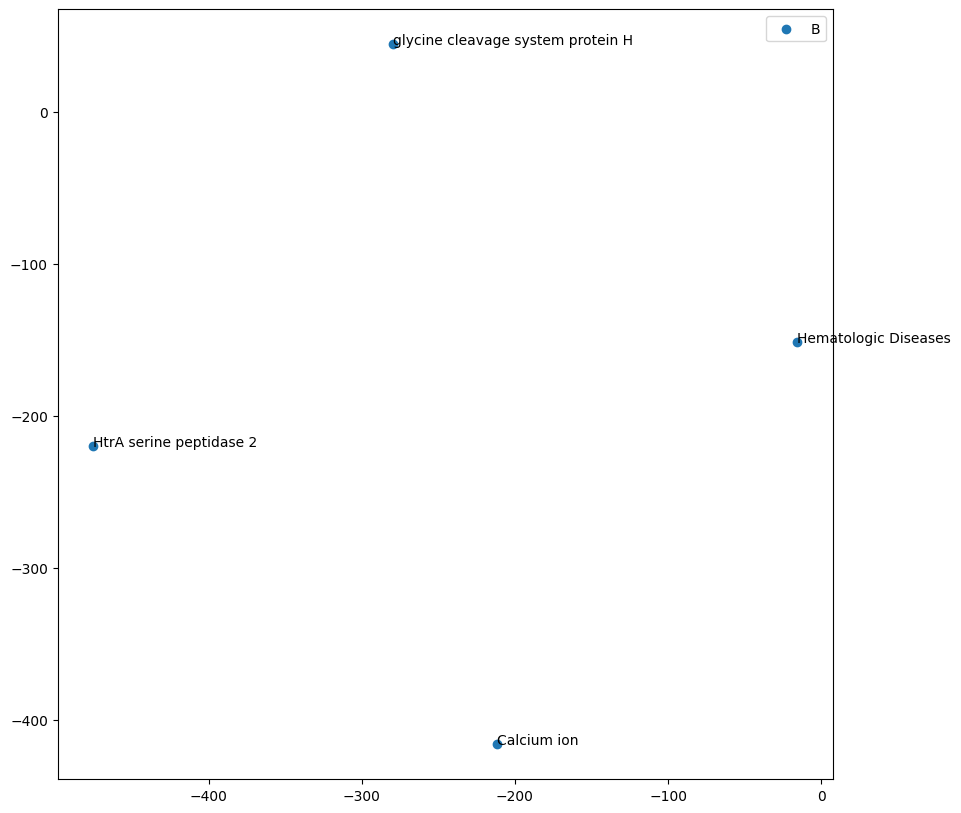

In [102]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def tokenize_text(text, tokenizer):
    text = tokenizer.sep_token.join(text)
    all_ents = ''.join(text.split(tokenizer.sep_token)).split('interacts_with')
    offsets = {ent: (text.find(ent), text.find(ent)+len(ent)) for ent in all_ents}
    tokenized_data = tokenizer(text, return_offsets_mapping=True, return_tensors='pt')
    return tokenized_data, offsets

def get_model_embeddings(model, inputs):
    with torch.no_grad():
        model_out = model(**inputs)
    lhs = model_out.last_hidden_state
    lhs = lhs.reshape(-1, 768)
    return lhs

def get_entity_embeddings(token_offsets, offsets_mapping, last_hidden_state):
    offsets_mapping = offsets_mapping.squeeze(0)[1:-1]
    embeds = {}
    for word, token_offset in token_offsets.items():
        start, end = token_offset
        new_start = (offsets_mapping[:, 0] == start).nonzero(as_tuple=True)
        new_end = (offsets_mapping[:, 1] == end).nonzero(as_tuple=True)
        embs = last_hidden_state[new_start[0]+1: new_end[0]+1]
        embeds[word] = embs.mean(dim=0)
    return embeds

def plot_embeddings(embeddings, model_name):
    tsne = TSNE(n_components=2, init='pca')
    embeds = [embeddings[k].numpy() for k in sorted(embeddings.keys())]
    tsne_embeds = tsne.fit_transform(embeds)
    plt.figure(figsize=(10, 10))
    plt.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1])
    plt.legend(model_name, loc='upper right')
    for label, x, y in zip(sorted(embeddings.keys()), tsne_embeds[:, 0], tsne_embeds[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()

def main():
    # Initialize model and tokenizer
    model_name = 'bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Define input text
    text = ['glycine cleavage system protein H',
            'interacts_with',
            'Calcium ion',
            'interacts_with',
            'HtrA serine peptidase 2',
            'interacts_with',
            'Hematologic Diseases']

    # Tokenize text and get offsets
    tokenized_data, offsets = tokenize_text(text, tokenizer)

    # Remove 'offset_mapping' from inputs (used in model)
    inputs = {k: v for k, v in tokenized_data.items() if k != 'offset_mapping'}

    # Get model embeddings
    model_embeddings = get_model_embeddings(model, inputs)

    # Get entity embeddings
    entity_embeddings = get_entity_embeddings(offsets, tokenized_data['offset_mapping'], model_embeddings)

    # Plot embeddings using t-SNE
    plot_embeddings(entity_embeddings, 'BERT')

if __name__ == "__main__":
    main()
